# Training Retinanet with custom dataset

In this notebook an existing dataset used for face detection is converted to a format with which it can be used with pretrained Retinanet model. The dataset is the face detection dataset from Kaggle: https://www.kaggle.com/dataturks/face-detection-in-images.

Then the pretrained RetinaNet model is trained with this dataset.

The code is applied based on Lazyprogrammer's Advanced computer vision course.

## 1. Import the packages

In [2]:
!git clone https://github.com/fizyr/keras-retinanet.git

Cloning into 'keras-retinanet'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (8/8), done.
remote: Total 6205 (delta 1), reused 3 (delta 1), pack-reused 6196
Receiving objects: 100% (6205/6205), 14.88 MiB | 7.90 MiB/s, done.
Resolving deltas: 100% (4191/4191), done.


In [3]:
%cd keras-retinanet/
!pip install .

/content/keras-retinanet
Processing /content/keras-retinanet
  Created wheel for keras-retinanet: filename=keras_retinanet-1.0.0-cp36-cp36m-linux_x86_64.whl size=168080 sha256=d08f3044338bd2b405ed41050952528578b08a641e550290f8e185ae636e613b
  Stored in directory: /root/.cache/pip/wheels/b2/9f/57/cb0305f6f5a41fc3c11ad67b8cedfbe9127775b563337827ba
  Created wheel for keras-resnet: filename=keras_resnet-0.2.0-py2.py3-none-any.whl size=20487 sha256=493bb90ff31c0de99b1394d7b9c0da5a73fb0ef961076e0de4f7971affe66348
  Stored in directory: /root/.cache/pip/wheels/5f/09/a5/497a30fd9ad9964e98a1254d1e164bcd1b8a5eda36197ecb3c
Successfully built keras-retinanet keras-resnet


In [4]:
!python setup.py build_ext --inplace

running build_ext
cythoning keras_retinanet/utils/compute_overlap.pyx to keras_retinanet/utils/compute_overlap.c
/usr/local/lib/python3.6/dist-packages/Cython/Compiler/Main.py:369: FutureWarning: Cython directive 'language_level' not set, using 2 for now (Py2). This will change in a later release! File: /content/keras-retinanet/keras_retinanet/utils/compute_overlap.pyx
  tree = Parsing.p_module(s, pxd, full_module_name)
building 'keras_retinanet.utils.compute_overlap' extension
creating build
creating build/temp.linux-x86_64-3.6
creating build/temp.linux-x86_64-3.6/keras_retinanet
creating build/temp.linux-x86_64-3.6/keras_retinanet/utils
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -g -fstack-protector-strong -Wformat -Werror=format-security -Wdate-time -D_FORTIFY_SOURCE=2 -fPIC -I/usr/include/python3.6m -I/usr/local/lib/python3.6/dist-packages/numpy/core/include -c keras_retinanet/utils/compute_overlap.c -o build/temp.linux-x86_64-3.6/keras_retinanet/utils/compute_over

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import requests
import urllib
import os
from PIL import Image
import json

from keras_retinanet import models
from keras_retinanet.utils.image import preprocess_image, resize_image
from keras_retinanet.utils.visualization import draw_box, draw_caption
from keras_retinanet.utils.colors import label_color

## 2. Load the face detection dataset

In [6]:
!wget -nc https://lazyprogrammer.me/course_files/face_detection.json

--2020-12-05 13:22:45--  https://lazyprogrammer.me/course_files/face_detection.json
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.81.48, 104.31.80.48, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.81.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273830 (267K) [application/json]
Saving to: ‘face_detection.json’

face_detection.json 100%[===================>] 267.41K  29.7KB/s    in 9.0s    

2020-12-05 13:22:55 (29.7 KB/s) - ‘face_detection.json’ saved [273830/273830]



In [7]:
!head face_detection.json

{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.08615384615384615,"y":0.3063063063063063},{"x":0.1723076923076923,"y":0.45345345345345345}],"imageWidth":650,"imageHeight":333},{"label":["Face"],"notes":"","points":[{"x":0.583076923076923,"y":0.2912912912912913},{"x":0.6584615384615384,"y":0.46846846846846846}],"imageWidth":650,"imageHeight":333}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/d1c32c8e-8050-482d-a6c8-b101ccba5b65___0de0ee708a4a47039e441d488615ebb7.png","annotation":[{"label":["Face"],"notes":"","points":[{"x":0.7053087757313109,"y":0.23260437375745527},{"x":0.7692307692307693,"y":0.36182902584493043}],"imageWidth":1280,"imageHeight":697}],"extras":null}
{"content": "http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e00

In [8]:
# Let's look at one line of this file
j=json.loads(open('face_detection.json').readline())
j

{'annotation': [{'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.08615384615384615, 'y': 0.3063063063063063},
    {'x': 0.1723076923076923, 'y': 0.45345345345345345}]},
  {'imageHeight': 333,
   'imageWidth': 650,
   'label': ['Face'],
   'notes': '',
   'points': [{'x': 0.583076923076923, 'y': 0.2912912912912913},
    {'x': 0.6584615384615384, 'y': 0.46846846846846846}]}],
 'content': 'http://com.dataturks.a96-i23.open.s3.amazonaws.com/2c9fafb064277d86016431e33e4e003d/8186c3d1-e9d4-4550-8ec1-a062a7628787___0-26.jpg.jpeg',
 'extras': None}

In [9]:
# Read the json file to pandas data frame
df=pd.read_json('face_detection.json',lines=True)
df.head()

,content,annotation,extras
0,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
1,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
2,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
3,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN
4,http://com.dataturks.a96-i23.open.s3.amazonaws...,"[{'label': ['Face'], 'notes': '', 'points': [{...",NaN


In [9]:
df.shape

(409, 3)

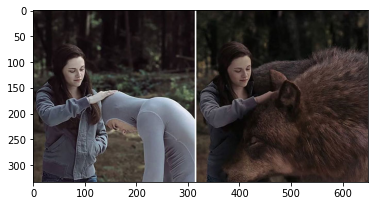

In [10]:
#Let's look at one of the images:
r=requests.get(df['content'][0])
with open('testing.jpg','wb') as file:
  file.write(r.content)
img=Image.open('testing.jpg')
plt.imshow(img)

## 3. Convert the dataset to suit for Retinanet

In [10]:
# Define the dictionaries for train and test set in the correct format for Retinanet
converted_data_train = {
    'image_name': [], # file path
    'x_min': [], # non-scaled coordinates
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

converted_data_test = {
    'image_name': [],
    'x_min': [],
    'y_min': [],
    'x_max': [],
    'y_max': [],
    'class_name': [],
}

In [11]:
# Create directory faces where the images are stored
if not os.path.exists('faces'):
  os.mkdir('faces')

In [12]:
# Define a function that converts the data frame to desired format
# the parameters are : row of the input data frame, and the resulting converted data frame
idx=0
def map_to_data(row,converted_data):
  global idx
  r=requests.get(row['content'])
  filepath=f"faces/face_{idx}.jpg"
  if not os.path.exists(filepath): 
    with open(filepath,'wb') as f:
      f.write(r.content)
  
  for anno in row['annotation']:  # there may be several annotations per image
    converted_data['image_name'].append(filepath)  

    height=anno['imageHeight']
    width=anno['imageWidth']
    x1=int(round(anno['points'][0]['x']*width))
    y1=int(round(anno['points'][0]['y']*height))
    x2=int(round(anno['points'][1]['x']*width))
    y2=int(round(anno['points'][1]['y']*height))

    converted_data['x_min'].append(x1)
    converted_data['y_min'].append(y1)
    converted_data['x_max'].append(x2)
    converted_data['y_max'].append(y2)

    converted_data['class_name'].append('face')
    idx+=1

In [13]:
# Split the data set to train and test part
train_df, test_df= train_test_split(df,test_size=0.2)

# Only after that create the converted dataset dictionaries
# This ensures that train and test sets have different images
idx=0
train_df.apply(lambda row: map_to_data(row,converted_data_train),axis=1)
test_df.apply(lambda row: map_to_data(row,converted_data_test),axis=1)

218    None
85     None
132    None
201    None
141    None
       ... 
146    None
368    None
15     None
42     None
153    None
Length: 82, dtype: object

In [14]:
#Create dataframes from converted dictionaries
#Note that the same image may be in several rows (several objects per image)
train_df=pd.DataFrame(converted_data_train)
test_df=pd.DataFrame(converted_data_test)
train_df.head()

,image_name,x_min,y_min,x_max,y_max,class_name
0,faces/face_0.jpg,216,229,331,350,face
1,faces/face_0.jpg,359,231,486,347,face
2,faces/face_0.jpg,531,191,629,296,face
3,faces/face_0.jpg,611,162,685,276,face
4,faces/face_0.jpg,735,138,827,242,face


In [16]:
train_df.shape, test_df.shape

((927, 6), (205, 6))

In [17]:
train_df['image_name'].sample().iloc[0]

'faces/face_301.jpg'

In [15]:
# Save the data frames to csv files
train_df.to_csv('annotations.csv',header=False,index=False)
# Class names are needed for captions for detected boxes
# although we have here only one class

!head annotations.csv

classes = ['face']
with open('classes.csv', 'w') as f:
  for i, class_name in enumerate(classes):
    f.write(f'{class_name},{i}\n')

!head classes.csv

faces/face_0.jpg,216,229,331,350,face
faces/face_0.jpg,359,231,486,347,face
faces/face_0.jpg,531,191,629,296,face
faces/face_0.jpg,611,162,685,276,face
faces/face_0.jpg,735,138,827,242,face
faces/face_0.jpg,650,63,735,175,face
faces/face_6.jpg,415,77,472,144,face
faces/face_6.jpg,58,56,136,118,face
faces/face_8.jpg,264,91,526,371,face
faces/face_8.jpg,94,126,314,418,face
face,0


## 4. Look at the dataset

In [19]:
# Create function that draws true boxes for objects for the sampled image
def show_image_with_boxes(df):
  filepath=df['image_name'].sample().iloc[0]
  df_img=df[df['image_name']==filepath] # include all rows containing this image
  img=np.array(Image.open(filepath))
  img=img[:,:,:3]

  for index, row in df_img.iterrows():
    box = [row['x_min'],row['y_min'],row['x_max'],row['y_max']]
    print(box)
    draw_box(img,box,color=(255,0,0)) # in red
  plt.axis('off')
  plt.imshow(img)
  plt.show()

[1656, 631, 2136, 1246]
[1363, 1356, 1782, 1934]
[2560, 1254, 2967, 1861]
[2962, 460, 3365, 1116]
[3626, 912, 3927, 1421]


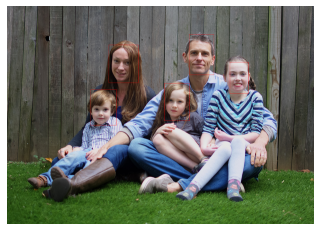

In [20]:
# Test the function:
show_image_with_boxes(train_df)

## 5. Train the RetinaNet model with face detection dataset

We start the training with the pretrained model, since that will make the training faster.

In [21]:
# Create directory for the model snapshots to be saved during training
if not os.path.exists('snapshots'):
  os.mkdir('snapshots')

In [16]:
# Download the pretrained RetinaNet model
PRETRAINED_MODEL='snapshots/_pretrained_model.h5'
URL='https://github.com/fizyr/keras-retinanet/releases/download/0.5.1/resnet50_coco_best_v2.1.0.h5'
urllib.request.urlretrieve(URL,PRETRAINED_MODEL)
print('Downloaded pretrained model to ' + PRETRAINED_MODEL)


Downloaded pretrained model to snapshots/_pretrained_model.h5


In [18]:
!keras_retinanet/bin/train.py --freeze-backbone \
  --random-transform \
  --weights {PRETRAINED_MODEL} \
  --batch-size 8 \
  --steps 500 \
  --epochs 15 \
  csv annotations.csv classes.csv

2020-12-05 13:37:10.020383: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Creating model, this may take a second...
2020-12-05 13:37:11.391822: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-12-05 13:37:11.418021: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-12-05 13:37:11.418638: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P4 computeCapability: 6.1
coreClock: 1.1135GHz coreCount: 20 deviceMemorySize: 7.43GiB deviceMemoryBandwidth: 178.99GiB/s
2020-12-05 13:37:11.418681: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-12-05 13:37:11.420322: I 

In [19]:
# Check if snapshots of the model are saved
!ls snapshots

_pretrained_model.h5  resnet50_csv_01.h5


## 6. Perform face detection with the trained model

In [20]:
from glob import glob
model_paths = glob('snapshots/resnet50_csv_*.h5')
latest_path = sorted(model_paths)[-1]
print("path:", latest_path)

model = models.load_model(latest_path, backbone_name='resnet50')
model = models.convert_model(model)

label_map = {}
for line in open('classes.csv'):
  row = line.rstrip().split(',')
  label_map[int(row[1])] = row[0]

path: snapshots/resnet50_csv_01.h5


In [21]:
def show_image_with_predictions(df, threshold=0.6):
  # choose a random image
  row = df.sample()
  filepath = row['image_name'].values[0]
  print("filepath:", filepath)

  # get all rows for this image
  df2 = df[df['image_name'] == filepath]
  im = np.array(Image.open(filepath))
  print("im.shape:", im.shape)

  # if there's a PNG it will have alpha channel
  im = im[:,:,:3]

  # plot true boxes
  for idx, row in df2.iterrows():
    box = [
      row['x_min'],
      row['y_min'],
      row['x_max'],
      row['y_max'],
    ]
    print(box)
    draw_box(im, box, color=(255, 0, 0))
  
  ### plot predictions ###

  # get predictions
  imp = preprocess_image(im)
  imp, scale = resize_image(im)

  boxes, scores, labels = model.predict_on_batch(
    np.expand_dims(imp, axis=0)
  )

  # standardize box coordinates
  boxes /= scale

  # loop through each prediction for the input image
  for box, score, label in zip(boxes[0], scores[0], labels[0]):
    # scores are sorted so we can quit as soon
    # as we see a score below threshold
    if score < threshold:
      break

    box = box.astype(np.int32)
    color = label_color(label)
    draw_box(im, box, color=color)

    class_name = label_map[label]
    caption = f"{class_name} {score:.3f}"
    draw_caption(im, box, caption)

  plt.axis('off')
  plt.imshow(im)
  plt.show()


In [22]:
plt.rcParams['figure.figsize'] = [20, 10]

filepath: faces/face_506.jpg
im.shape: (678, 1024, 3)
[223, 153, 287, 208]
[272, 246, 336, 307]
[322, 353, 389, 407]
[348, 206, 407, 257]
[534, 277, 590, 335]
[426, 300, 487, 354]
[362, 102, 423, 161]
[498, 117, 562, 174]
[453, 188, 514, 245]
[571, 184, 628, 239]
[618, 104, 669, 162]
[681, 163, 733, 212]
[662, 269, 726, 323]
[823, 252, 889, 321]
[742, 100, 799, 154]
[792, 160, 845, 217]


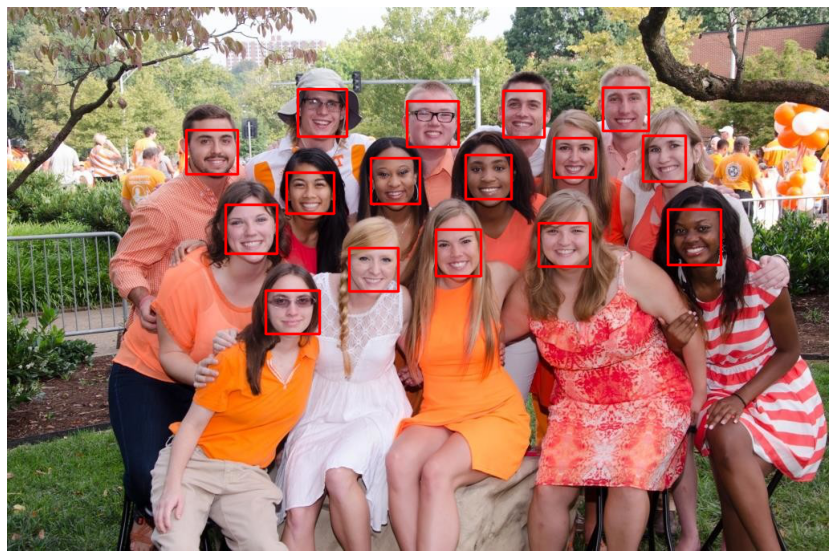

In [23]:
show_image_with_predictions(train_df, threshold=0.3)

filepath: faces/face_1057.jpg
im.shape: (360, 480, 3)
[52, 65, 179, 147]


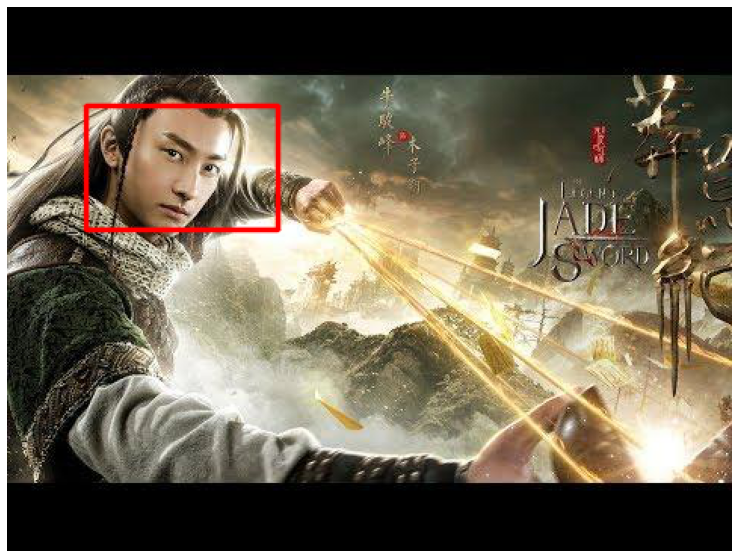

In [24]:
show_image_with_predictions(test_df, threshold=0.4)